combining code from Properties.ipynb and ObservedTrend.ipynb to make plots of trends over distance and time for the paper

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
from scipy.interpolate import UnivariateSpline

import warnings
warnings.filterwarnings("ignore")

IOPATH = '/ocean/rbeutel/MOAD/analysis-becca/Synthesis/data/CCS_obs.csv'

In [2]:
obs = pd.read_csv(IOPATH)

In [3]:
# reduce potential bias caused by sampling programs going out in different months
# summer only (april-sep inclusive) based on PreliminaryCurrentAnalysis.ipynb
obs = obs[(obs.month>=4)&(obs.month<=9)]
obs

,Unnamed: 0.1,Unnamed: 0,time,longitude (degrees_east),latitude (degrees_north),depth (m),pressure (dbar),temperature (degC),salinity (g kg-1),density (kg m-3),...,Ni (nmol kg-1),Zn (nmol kg-1),source,current,location,[TA-DIC] (uM),year,month,NSdist,EWdist
0,0,0,1933-07-25 00:00:00+00:00,-126.76,49.34,1.0,1.008587,NaN,32.070847,NaN,...,NaN,NaN,ios bottle,shelf,shelf,NaN,1933,7,0.000000,-0.0
1,1,1,1933-07-25 00:00:00+00:00,-126.76,49.34,2.0,2.017180,NaN,32.090943,NaN,...,NaN,NaN,ios bottle,shelf,shelf,NaN,1933,7,0.000000,-0.0
2,2,2,1933-07-25 00:00:00+00:00,-126.76,49.34,4.0,4.034378,NaN,32.090906,NaN,...,NaN,NaN,ios bottle,shelf,shelf,NaN,1933,7,0.000000,-0.0
3,3,3,1933-07-25 00:00:00+00:00,-126.76,49.34,6.0,6.051598,NaN,32.090870,NaN,...,NaN,NaN,ios bottle,shelf,shelf,NaN,1933,7,0.000000,-0.0
4,4,4,1933-07-25 00:00:00+00:00,-126.76,49.34,10.0,10.086095,NaN,32.181305,NaN,...,NaN,NaN,ios bottle,shelf,shelf,NaN,1933,7,0.000000,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1346330,1346330,1401508,2024-09-30 00:00:00+00:00,-124.57,46.99,0.0,0.000000,10.000050,33.328536,1025.527358,...,NaN,NaN,ooi,shelf,shelf,NaN,2024,9,215.824564,-0.0
1346331,1346331,1401509,2024-09-30 00:00:00+00:00,-124.56,46.99,0.0,0.000000,12.388119,32.661681,1024.585241,...,NaN,NaN,ooi,shelf,shelf,NaN,2024,9,215.824564,-0.0
1346332,1346332,1401510,2024-09-30 00:00:00+00:00,-124.31,44.64,0.0,0.000000,9.441516,33.522238,1025.769626,...,NaN,NaN,ooi,shelf,shelf,NaN,2024,9,446.476618,NaN
1346333,1346333,1401511,2024-09-30 00:00:00+00:00,-124.27,47.13,0.0,0.000000,11.669242,32.555657,1024.637082,...,NaN,NaN,ooi,shelf,shelf,NaN,2024,9,215.824564,-0.0


In [4]:
# Setting up different currents
obs_shelf = obs[obs['current'] == 'shelf']
obs_cuc = obs[obs['current'] == 'CUC']
obs_cc = obs[obs['current'] == 'CC']

# make a 'dist' column of the distances we're actually going to use for each current
# for shelf and cuc its simply the NS dist

obs_cuc['dist'] = obs_cuc.NSdist
obs_shelf['dist'] = obs_shelf.NSdist

# for the CC its a bit more complicated
# first, just pick whatever line the point is closer to
abs_a = obs_cc.NSdist.abs()
abs_b = obs_cc.EWdist.abs()

obs_cc['dist'] = np.select(
    [
        abs_a < abs_b,       # a closer to zero
        abs_b < abs_a,       # b closer to zero
        abs_a.isna(),        # a NaN, take b
        abs_b.isna()         # b NaN, take a
    ],
    [
        obs_cc.NSdist,
        obs_cc.EWdist,
        obs_cc.EWdist,
        obs_cc.NSdist
    ],
    default=np.nan
)

# and then also default that anywhere that the NS dist is -ve, the EW distance should be taken
obs_cc.dist[obs_cc.NSdist < 0] = obs_cc.EWdist

# Functions

In [5]:
def plot_property_NStrend(d_out, var_string, current_string, subplot_pos):
    if current_string == 'CUC':
        obs_used = obs_cuc
    elif current_string == 'shelf':
        obs_used = obs_shelf
    elif current_string == 'CC':
        obs_used = obs_cc
    else:
        raise ValueError("Invalid current_string. Use 'CC', 'CUC', or 'shelf'.")

    ylim_dict = {'spice': [-2, 3], 'temperature (degC)': [5, 20], 'salinity (g kg-1)': [31, 35],
                 'DO (umol kg-1)': [0,400], 'NO3 (uM)': [0,40], '[TA-DIC] (uM)': [-50,300]}

    x = np.asarray(d_out)
    y = np.asarray(obs_used[var_string])
    m = np.isfinite(x) & np.isfinite(y)
    if m.sum() < 5:
        raise ValueError("Not enough finite data to fit a trend.")

    # --- bin distances (vectorized) ---
    base = 200.0
    x_bin = np.round(x[m] / base) * base

    df = pd.DataFrame({'x_bin': x_bin, 'y': y[m]})
    g = df.groupby('x_bin', sort=True)

    xu   = g['y'].mean().index.values
    ybar = g['y'].mean().values
    s    = g['y'].std(ddof=1).values
    n    = g.size().values

    # --- drop small-n bins ---
    keep = n >= 3
    xu, ybar, s, n = xu[keep], ybar[keep], s[keep], n[keep]
    if xu.size < 5:
        raise ValueError("Too few bins with n≥3 to fit a smooth trend.")

    # --- standard error and t-crit ---
    se = s / np.sqrt(n)
    dfree = np.maximum(n - 1, 1)  # avoid 0
    tcrit = stats.t.ppf(0.975, df=dfree)

    # --- smoothing: weighted spline on mean; separate smooth on log(se) ---
    # weights = 1/se (clip to avoid infinities)
    se_clip = np.clip(se, np.nanmax(se)*1e-6, np.nanmax(se)*1e6)
    w = 1.0 / se_clip

    # --- cap leverage of dominant bins so we don't get crazy jumps just bc there's a lot of data
    max_ratio = 10.0  # max allowed ratio of (weight / median weight)
    med_w = np.median(w)
    w = np.minimum(w, med_w * max_ratio)
    w /= med_w  # normalize so median weight ~ 1
    # ===========================================

    # Choose s proportional to variance * number of points (rule of thumb)
    s_mean = np.nanvar(ybar) * xu.size

    mean_spline = UnivariateSpline(xu, ybar, w=w, s=s_mean)

    # Smooth log(SE) to keep positivity and avoid negative wiggles
    se_pos = np.clip(se, np.finfo(float).eps, None)
    logse_spline = UnivariateSpline(xu, np.log(se_pos), s=xu.size * 0.5)

    # Evaluate on a fine grid
    x_fine = np.linspace(xu.min(), xu.max(), 600)
    y_smooth = mean_spline(x_fine)
    se_smooth = np.exp(logse_spline(x_fine))

    # tcrit varies slowly with n; use median df for evaluation (or spline tcrit too)
    tcrit_med = stats.t.ppf(0.975, df=int(np.median(dfree)))
    lower = y_smooth - tcrit_med * se_smooth
    upper = y_smooth + tcrit_med * se_smooth

    # --- plot ---
    ax[subplot_pos].scatter(x[m], y[m], s=2, alpha=0.1, c='k', linewidths=0)
    ax[subplot_pos].plot(x_fine, y_smooth, lw=2, label='Trend (weighted spline)', color='blue')
    ax[subplot_pos].fill_between(x_fine, lower, upper, color='blue', alpha=0.4, label='95% CI (approx)')

    if var_string in ylim_dict:
        ax[subplot_pos].set_ylim(ylim_dict[var_string])

    ax[subplot_pos].set_xlim(-1400, 2500)
    ax[subplot_pos].set_xlim(-1400, 2500)
    ax[subplot_pos].set_xticks([-1000,-500,0,500,1000,1500,2000])
    ax[subplot_pos].set_xticklabels([])
    # ax[subplot_pos].set_xlabel('Distance Along Line (km)')
    # ax[subplot_pos].set_ylabel('Spice (kg m-3)' if var_string == 'spice' else var_string)
    # ax[subplot_pos].set_title(f'{var_string} trend down {current_string}')
    # ax[subplot_pos].grid(True)
    # ax[subplot_pos].legend()

    # add lines for JdF, Cape Mendocino, and Point Conception
    # add lines for JdF, Cape Mendocino, and Point Conception
    ax[subplot_pos].plot([0,0],[-1000,1000],'k--',alpha=0.5) # JdF
    ax[subplot_pos].plot([900,900],[-1000,1000],'k--',alpha=0.5) # Cape Mendocino
    ax[subplot_pos].plot([1675,1675],[-1000,1000],'k--',alpha=0.5) # Point Conception
    # ax[subplot_pos].text(0.34,0.02,'JdF',ha='right',va='bottom',transform=ax[subplot_pos].transAxes,fontsize=10)
    # ax[subplot_pos].text(0.57,0.02,'CM',ha='right',va='bottom',transform=ax[subplot_pos].transAxes,fontsize=10)
    # ax[subplot_pos].text(0.77,0.02,'PC',ha='right',va='bottom',transform=ax[subplot_pos].transAxes,fontsize=10)

    # return xu, ybar


In [6]:
##################
# Trends in time #
##################

def plot_ratediff_NS_CI(var_string, current_string, subplot_pos, yrlabel=False,
                        n_bins=9, cov_type="HAC", hac_maxlags=1,
                        annual_stat="median", min_obs_per_year=3,
                        min_years=4, min_span_years=10):
    # pick data by current
    if current_string == 'CUC':
        obs_used = obs_cuc
    elif current_string == 'shelf':
        obs_used = obs_shelf
    elif current_string == 'CC':
        obs_used = obs_cc
    else:
        raise ValueError("Invalid current_string. Use 'CC', 'CUC', or 'shelf'.")

    ylim_dict = {'spice':[-0.04,0.02], 'temperature (degC)': [-0.2,0.2],
                 'salinity (g kg-1)':[-0.03,0.03], 'DO (umol kg-1)':[-3.5,2],
                 'NO3 (uM)':[-2.3,1], '[TA-DIC] (uM)':[-10,17]}

    # bin edges/centers/widths
    dist = np.asarray(obs_used['dist'])
    dmin, dmax = -1400, 2500
    edges   = np.linspace(dmin, dmax, n_bins+1)
    centers = 0.5 * (edges[:-1] + edges[1:])
    # keep your "narrow bar" choice but ensure width is positive
    widths  = np.maximum((edges[1:] - edges[:-1]) - 200, 1e-6)

    slopes      = np.full(n_bins, np.nan)
    lo95        = np.full(n_bins, np.nan)
    hi95        = np.full(n_bins, np.nan)
    year_span   = np.full(n_bins, np.nan)   # NaN => excluded
    n_years_arr = np.full(n_bins, np.nan)

    years_all = np.asarray(obs_used['year'])
    y_all     = np.asarray(obs_used[var_string])

    for i in range(n_bins):
        lo, hi = edges[i], edges[i+1]
        msk = (dist >= lo) & (dist < hi) & np.isfinite(years_all) & np.isfinite(y_all)
        if not np.any(msk):
            continue

        # (1) aggregate to annual values with ≥ min_obs_per_year
        df_bin = pd.DataFrame({
            "year": years_all[msk].astype(float),
            "val":  y_all[msk].astype(float)
        })

        # distinct years and span
        n_years = len(set(df_bin["year"]))
        span = float(df_bin["year"].max() - df_bin["year"].min() + 1)

        if (n_years < min_years) or (span < min_span_years):
            # exclude this bin from both points and bars
            continue

        grp = df_bin.groupby("year", as_index=False).agg(
            n=("val", "size"),
            med=("val", "median"),
            mean=("val", "mean")
        )
        grp = grp[grp["n"] >= min_obs_per_year]
        if grp.empty:
            continue

        n_years_arr[i] = n_years
        year_span[i]   = span

        Y_ann = grp["med"].values if annual_stat == "median" else grp["mean"].values
        X_ann = grp["year"].values

        # (2) OLS with equal weight per year + (3) robust SEs
        X = sm.add_constant(X_ann)
        ols = sm.OLS(Y_ann, X)
        if cov_type == "HAC":
            res = ols.fit(cov_type="HAC", cov_kwds={"maxlags": int(hac_maxlags)})
        else:
            res = ols.fit(cov_type=cov_type)

        slopes[i] = res.params[1]
        ci = res.conf_int(alpha=0.05)
        if ci.shape[0] > 1:
            lo95[i], hi95[i] = ci[1, 0], ci[1, 1]

    # === plotting ===
    ax_tr = ax[subplot_pos]
    ax_yr = ax_tr.twinx()

    # Only plot bars for bins that passed filters
    m_bar = np.isfinite(year_span)
    if np.any(m_bar):
        ax_yr.bar(centers[m_bar], year_span[m_bar], width=widths[m_bar],
                  color='lightblue', alpha=0.7, zorder=1)
    ax_yr.set_ylim([0,100])
    ax_yr.set_yticks([10,20,30,40,50,60,70,80,90,100])
    ax_yr.grid(axis='y',color='w',zorder=2)
    if yrlabel==True:
        ax_yr.set_ylabel('Year-span (yr)',fontsize=10)
        ax_yr.set_yticklabels(['','20','','40','','60','','80','','100'],fontsize=8)
    else:
        ax_yr.set_yticklabels([])


    # points + 95% CI for valid bins only
    m_ok = np.isfinite(slopes) & np.isfinite(lo95) & np.isfinite(hi95)
    if np.any(m_ok):
        yerr = np.vstack([hi95[m_ok] - slopes[m_ok], slopes[m_ok] - lo95[m_ok]])
        ax_tr.errorbar(centers[m_ok], slopes[m_ok], yerr=yerr, fmt='.', ms=7,
                       c='darkblue', label='95% CI',zorder=4)

    ax_tr.set_xlim(-1400, 2500)
    ax_tr.set_xticks([-1000,-500,0,500,1000,1500,2000])
    ax_tr.set_xticklabels(['-1000','','0','','-1000','','-2000'],rotation=90)
    ax_tr.axhline(0, color='black', lw=1,zorder=3)

    if var_string in ylim_dict:
        ax_tr.set_ylim(ylim_dict[var_string])

    # add lines for JdF, Cape Mendocino, and Point Conception
    ax_tr.plot([0,0],[-1000,1000],'k--',alpha=0.5) # JdF
    ax_tr.plot([900,900],[-1000,1000],'k--',alpha=0.5) # Cape Mendocino
    ax_tr.plot([1675,1675],[-1000,1000],'k--',alpha=0.5) # Point Conception
    ax_tr.text(0.34,0.02,'JdF',ha='right',va='bottom',transform=ax_tr.transAxes,fontsize=10)
    ax_tr.text(0.57,0.02,'CM',ha='right',va='bottom',transform=ax_tr.transAxes,fontsize=10)
    ax_tr.text(0.77,0.02,'PC',ha='right',va='bottom',transform=ax_tr.transAxes,fontsize=10)

    ax_yr.set_zorder(1)
    ax_tr.set_zorder(3)
    ax_tr.patch.set_alpha(0)

# Temperature

In [7]:
# load in lit review results here

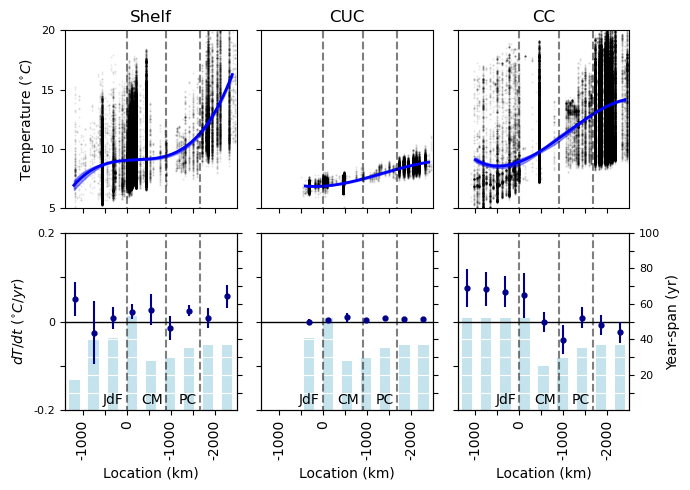

In [8]:
variable = 'temperature (degC)'

fig, ax = plt.subplots(2,3, figsize=(7,5))

# trend in space plot in top row
plot_property_NStrend(obs_shelf['dist'], variable, 'shelf', (0,0))
plot_property_NStrend(obs_cuc['dist'], variable, 'CUC', (0,1))
plot_property_NStrend(obs_cc['dist'], variable, 'CC', (0,2))
for i in range(3):
    ax[0,i].set_yticks([5,10,15,20])
    ax[0,i].set_yticklabels([])
ax[0,0].set_yticklabels(['5','10','15','20'],fontsize=8)
ax[0,0].set_ylabel('Temperature ($^{\circ} C$)',fontsize=10)


# trend in time plots in bottom row
plot_ratediff_NS_CI(variable, 'shelf', (1,0))
plot_ratediff_NS_CI(variable, 'CUC', (1,1))
plot_ratediff_NS_CI(variable, 'CC', (1,2),yrlabel=True)
for i in range(3):
    ax[1,i].set_yticks([-0.2,-0.1,0,0.1,0.2])
    ax[1,i].set_xlabel('Location (km)')
ax[1,0].set_ylabel('$dT/dt \,\,(^{\circ} C/yr)$',fontsize=10)
ax[1,0].set_yticklabels(['-0.2','','0','','0.2'],fontsize=8)
ax[1,1].set_yticklabels([])
ax[1,2].set_yticklabels([])

# titles
ax[0,0].set_title('Shelf')
ax[0,1].set_title('CUC')
ax[0,2].set_title('CC')

plt.tight_layout()

# Salinity

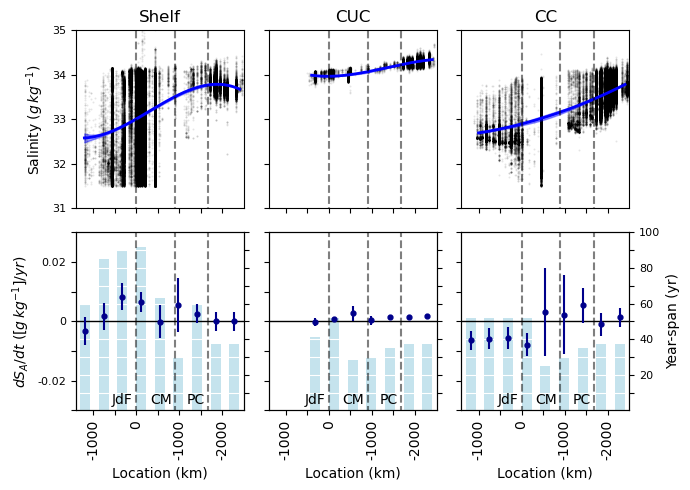

In [9]:
variable = 'salinity (g kg-1)'

fig, ax = plt.subplots(2,3, figsize=(7,5))

# trend in space plot in top row
plot_property_NStrend(obs_shelf['dist'], variable, 'shelf', (0,0))
plot_property_NStrend(obs_cuc['dist'], variable, 'CUC', (0,1))
plot_property_NStrend(obs_cc['dist'], variable, 'CC', (0,2))
for i in range(3):
    ax[0,i].set_yticks([31,32,33,34,35])
    ax[0,i].set_yticklabels([])
ax[0,0].set_yticklabels([31,32,33,34,35],fontsize=8)
ax[0,0].set_ylabel('Salinity ($g\,kg^{-1}$)',fontsize=10)


# trend in time plots in bottom row
plot_ratediff_NS_CI(variable, 'shelf', (1,0))
plot_ratediff_NS_CI(variable, 'CUC', (1,1))
plot_ratediff_NS_CI(variable, 'CC', (1,2),yrlabel=True)
for i in range(3):
    ax[1,i].set_yticks([-0.03,-0.02,-0.01,0,0.01,0.02,0.03])
    ax[1,i].set_xlabel('Location (km)')
ax[1,0].set_ylabel('$dS_A/dt \,\,([g\,kg^{-1}]/yr)$',fontsize=10)
ax[1,0].set_yticklabels(['','-0.02','','0','','0.02',''],fontsize=8)
ax[1,1].set_yticklabels([])
ax[1,2].set_yticklabels([])

# titles
ax[0,0].set_title('Shelf')
ax[0,1].set_title('CUC')
ax[0,2].set_title('CC')

plt.tight_layout()

# Spice

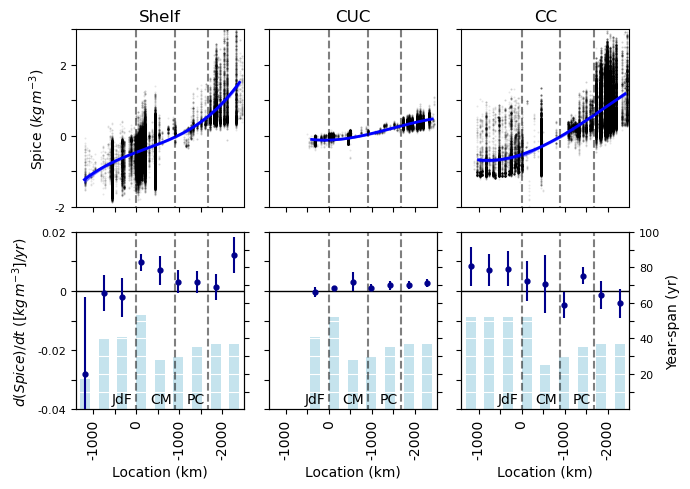

In [10]:
variable = 'spice'

fig, ax = plt.subplots(2,3, figsize=(7,5))

# trend in space plot in top row
plot_property_NStrend(obs_shelf['dist'], variable, 'shelf', (0,0))
plot_property_NStrend(obs_cuc['dist'], variable, 'CUC', (0,1))
plot_property_NStrend(obs_cc['dist'], variable, 'CC', (0,2))
for i in range(3):
    ax[0,i].set_yticks([-2,-1,0,1,2,3])
    ax[0,i].set_yticklabels([])
ax[0,0].set_yticklabels(['-2','','0','','2',''],fontsize=8)
ax[0,0].set_ylabel('Spice ($kg \, m^{-3}$)',fontsize=10)


# trend in time plots in bottom row
plot_ratediff_NS_CI(variable, 'shelf', (1,0))
plot_ratediff_NS_CI(variable, 'CUC', (1,1))
plot_ratediff_NS_CI(variable, 'CC', (1,2),yrlabel=True)
for i in range(3):
    ax[1,i].set_yticks([-0.04,-0.03,-0.02,-0.01,0,0.01,0.02])
    ax[1,i].set_xlabel('Location (km)')
ax[1,0].set_ylabel('$d(Spice)/dt \,\,([kg\,m^{-3}]/yr)$',fontsize=10)
ax[1,0].set_yticklabels(['-0.04','','-0.02','','0','','0.02'],fontsize=8)
ax[1,1].set_yticklabels([])
ax[1,2].set_yticklabels([])

# titles
ax[0,0].set_title('Shelf')
ax[0,1].set_title('CUC')
ax[0,2].set_title('CC')

plt.tight_layout()

# DO

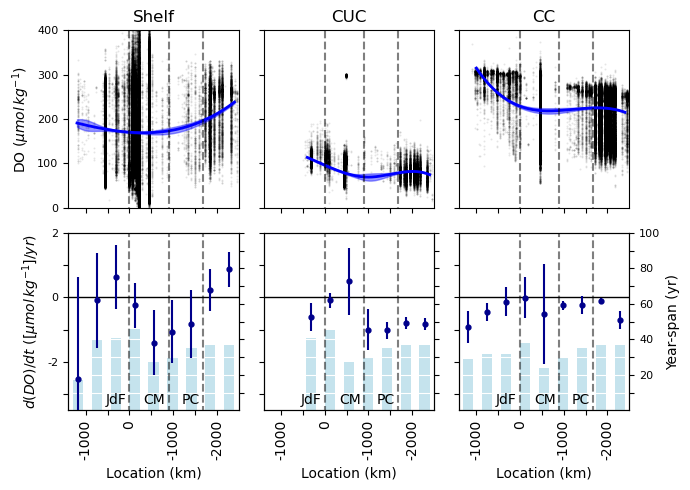

In [11]:
variable = 'DO (umol kg-1)'

fig, ax = plt.subplots(2,3, figsize=(7,5))

# trend in space plot in top row
plot_property_NStrend(obs_shelf['dist'], variable, 'shelf', (0,0))
plot_property_NStrend(obs_cuc['dist'], variable, 'CUC', (0,1))
plot_property_NStrend(obs_cc['dist'], variable, 'CC', (0,2))
for i in range(3):
    ax[0,i].set_yticks([0,100,200,300,400])
    ax[0,i].set_yticklabels([])
ax[0,0].set_yticklabels([0,100,200,300,400],fontsize=8)
ax[0,0].set_ylabel('DO ($\mu mol \,kg^{-1}$)',fontsize=10)


# trend in time plots in bottom row
plot_ratediff_NS_CI(variable, 'shelf', (1,0))
plot_ratediff_NS_CI(variable, 'CUC', (1,1))
plot_ratediff_NS_CI(variable, 'CC', (1,2),yrlabel=True)
for i in range(3):
    ax[1,i].set_yticks([-3,-2,-1,0,1,2])
    ax[1,i].set_xlabel('Location (km)')
ax[1,0].set_ylabel('$d(DO)/dt \,\,([\mu mol \,kg^{-1}]/yr)$',fontsize=10)
ax[1,0].set_yticklabels(['','-2','','0','','2'],fontsize=8)
ax[1,1].set_yticklabels([])
ax[1,2].set_yticklabels([])

# titles
ax[0,0].set_title('Shelf')
ax[0,1].set_title('CUC')
ax[0,2].set_title('CC')

plt.tight_layout()

# NO3

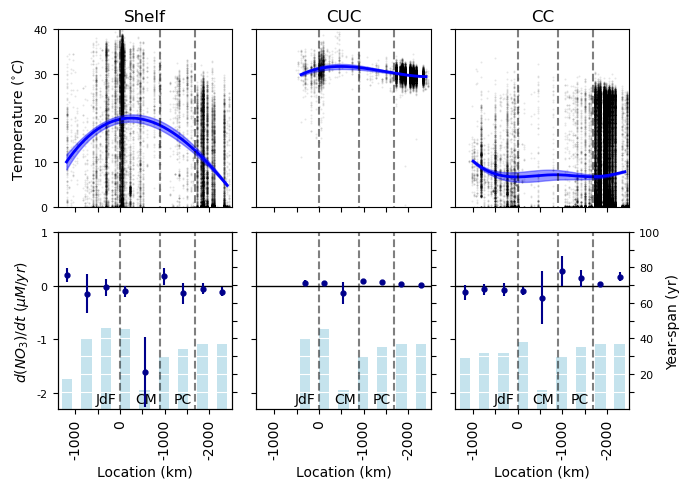

In [12]:
variable = 'NO3 (uM)'

fig, ax = plt.subplots(2,3, figsize=(7,5))

# trend in space plot in top row
plot_property_NStrend(obs_shelf['dist'], variable, 'shelf', (0,0))
plot_property_NStrend(obs_cuc['dist'], variable, 'CUC', (0,1))
plot_property_NStrend(obs_cc['dist'], variable, 'CC', (0,2))
for i in range(3):
    ax[0,i].set_yticks([0,10,20,30,40])
    ax[0,i].set_yticklabels([])
ax[0,0].set_yticklabels([0,10,20,30,40],fontsize=8)
ax[0,0].set_ylabel('Temperature ($^{\circ} C$)',fontsize=10)


# trend in time plots in bottom row
plot_ratediff_NS_CI(variable, 'shelf', (1,0))
plot_ratediff_NS_CI(variable, 'CUC', (1,1))
plot_ratediff_NS_CI(variable, 'CC', (1,2),yrlabel=True)
for i in range(3):
    ax[1,i].set_yticks([-2,-1,0,1])
    ax[1,i].set_xlabel('Location (km)')
ax[1,0].set_ylabel('$d(NO_3)/dt \,\,(\mu M/yr)$',fontsize=10)
ax[1,0].set_yticklabels([-2,-1,0,1],fontsize=8)
ax[1,1].set_yticklabels([])
ax[1,2].set_yticklabels([])

# titles
ax[0,0].set_title('Shelf')
ax[0,1].set_title('CUC')
ax[0,2].set_title('CC')

plt.tight_layout()

# [TA-DIC]

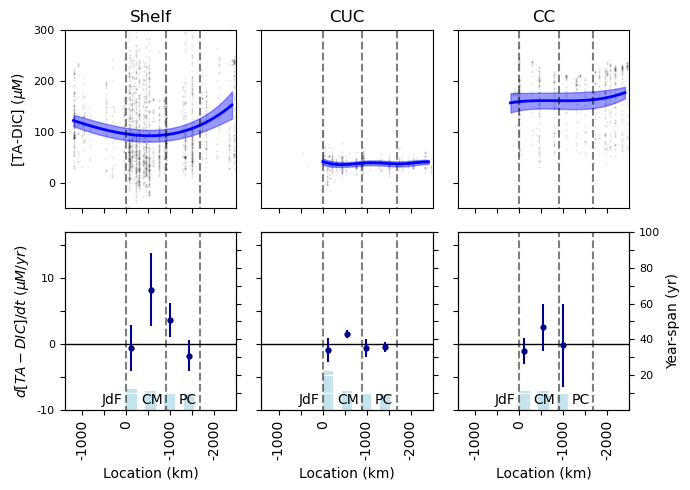

In [13]:
variable = '[TA-DIC] (uM)'

fig, ax = plt.subplots(2,3, figsize=(7,5))

# trend in space plot in top row
plot_property_NStrend(obs_shelf['dist'], variable, 'shelf', (0,0))
plot_property_NStrend(obs_cuc['dist'], variable, 'CUC', (0,1))
plot_property_NStrend(obs_cc['dist'], variable, 'CC', (0,2))
for i in range(3):
    ax[0,i].set_yticks([0,100,200,300])
    ax[0,i].set_yticklabels([])
ax[0,0].set_yticklabels([0,100,200,300],fontsize=8)
ax[0,0].set_ylabel('[TA-DIC] ($\mu M$)',fontsize=10)


# trend in time plots in bottom row
plot_ratediff_NS_CI(variable, 'shelf', (1,0))
plot_ratediff_NS_CI(variable, 'CUC', (1,1))
plot_ratediff_NS_CI(variable, 'CC', (1,2),yrlabel=True)
for i in range(3):
    ax[1,i].set_yticks([-10,-5,0,5,10,15])
    ax[1,i].set_xlabel('Location (km)')
ax[1,0].set_ylabel('$d[TA-DIC]/dt \,\,(\mu M/yr)$',fontsize=10)
ax[1,0].set_yticklabels(['-10','','0','','10',''],fontsize=8)
ax[1,1].set_yticklabels([])
ax[1,2].set_yticklabels([])

# titles
ax[0,0].set_title('Shelf')
ax[0,1].set_title('CUC')
ax[0,2].set_title('CC')

plt.tight_layout()